In [4]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Interactive Dashboard
import streamlit as st

# System operations
import os


In [7]:
import pandas as pd
import os

# Define the folder where the datasets are saved
data_path = r"C:\Users\Ameya\Documents\EB1A\Projects\Real Estate Project\To use"

# File names
file_names = {
    "days_market_pricecuts": "Days_market_pricecuts.csv",
    "for_sale_listings": "For_Sale_Listing.csv",
    "market_heat_index": "Market_heat_index.csv",
    "sales": "Sales.csv",
    "zhvi": "ZHVI.csv",
    "zori": "ZORI.csv",
}

# Load datasets into DataFrames
datasets = {}
for key, file in file_names.items():
    file_path = os.path.join(data_path, file)
    datasets[key] = pd.read_csv(file_path)

# Display loaded dataset names and their shapes
for key, df in datasets.items():
    print(f"{key}: {df.shape}")


days_market_pricecuts: (671, 86)
for_sale_listings: (928, 86)
market_heat_index: (928, 88)
sales: (94, 207)
zhvi: (895, 304)
zori: (627, 124)


In [8]:
# Inspect data types, column names, and missing values
for key, df in datasets.items():
    print(f"\nDataset: {key}")
    print(f"Columns: {df.columns.tolist()[:10]} ...")  # Display first 10 columns
    print(f"Missing Values:\n{df.isnull().sum()}\n")
    print(f"Data Types:\n{df.dtypes}\n")



Dataset: days_market_pricecuts
Columns: ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31'] ...
Missing Values:
RegionID       0
SizeRank       0
RegionName     0
RegionType     0
StateName      1
              ..
2024-07-31    30
2024-08-31    28
2024-09-30    26
2024-10-31    20
2024-11-30     1
Length: 86, dtype: int64

Data Types:
RegionID        int64
SizeRank        int64
RegionName     object
RegionType     object
StateName      object
               ...   
2024-07-31    float64
2024-08-31    float64
2024-09-30    float64
2024-10-31    float64
2024-11-30    float64
Length: 86, dtype: object


Dataset: for_sale_listings
Columns: ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31'] ...
Missing Values:
RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     1
             ..
2024-07-31    0
2024

In [9]:
# Example transformation for a single dataset (can be repeated for others)
def transform_time_series(df, key_columns):
    """
    Transforms a dataset with time-series columns into long format.
    Args:
        df (pd.DataFrame): The dataset to transform.
        key_columns (list): Columns to keep as identifiers.
    Returns:
        pd.DataFrame: Transformed dataset.
    """
    # Identify time-series columns (non-key columns)
    time_series_cols = [col for col in df.columns if col not in key_columns]
    
    # Transform to long format
    df_long = df.melt(id_vars=key_columns, value_vars=time_series_cols,
                      var_name="Date", value_name="Value")
    
    # Convert 'Date' to datetime format
    df_long['Date'] = pd.to_datetime(df_long['Date'], errors='coerce')
    
    return df_long

# Apply transformation to all datasets
key_columns = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']
transformed_datasets = {key: transform_time_series(df, key_columns) for key, df in datasets.items()}

# Display a sample of the transformed dataset
for key, df in transformed_datasets.items():
    print(f"\nTransformed {key}: {df.head()}")



Transformed days_market_pricecuts:    RegionID  SizeRank       RegionName RegionType StateName       Date  Value
0    102001         0    United States    country       NaN 2018-03-31   51.0
1    394913         1     New York, NY        msa        NY 2018-03-31   68.0
2    753899         2  Los Angeles, CA        msa        CA 2018-03-31   35.0
3    394463         3      Chicago, IL        msa        IL 2018-03-31   51.0
4    394514         4       Dallas, TX        msa        TX 2018-03-31   46.0

Transformed for_sale_listings:    RegionID  SizeRank       RegionName RegionType StateName       Date  \
0    102001         0    United States    country       NaN 2018-03-31   
1    394913         1     New York, NY        msa        NY 2018-03-31   
2    753899         2  Los Angeles, CA        msa        CA 2018-03-31   
3    394463         3      Chicago, IL        msa        IL 2018-03-31   
4    394514         4       Dallas, TX        msa        TX 2018-03-31   

       Value  
0  1

In [17]:
# Preprocess datasets to include RegionName for visualization
def preprocess_for_merge_with_name(df, value_column_name):
    """
    Prepares a DataFrame for merging by keeping the necessary columns.
    Args:
        df (pd.DataFrame): Input DataFrame.
        value_column_name (str): New name for the 'Value' column.
    Returns:
        pd.DataFrame: Preprocessed DataFrame with RegionName.
    """
    return df[['RegionID', 'Date', 'RegionName', 'Value']].rename(columns={'Value': value_column_name})

# Preprocess datasets
datasets_preprocessed_with_name = {
    'days_market_pricecuts': preprocess_for_merge_with_name(transformed_datasets['days_market_pricecuts'], 'PriceCuts'),
    'for_sale_listings': preprocess_for_merge_with_name(transformed_datasets['for_sale_listings'], 'ForSaleListings'),
    'market_heat_index': preprocess_for_merge_with_name(transformed_datasets['market_heat_index'], 'MarketHeat'),
    'sales': preprocess_for_merge_with_name(transformed_datasets['sales'], 'Sales'),
    'zhvi': preprocess_for_merge_with_name(transformed_datasets['zhvi'], 'ZHVI'),
    'zori': preprocess_for_merge_with_name(transformed_datasets['zori'], 'ZORI'),
}

# Merge datasets, ensuring RegionName is included
merged_data = reduce(
    lambda left, right: pd.merge(left, right, on=['RegionID', 'Date', 'RegionName'], how='outer'),
    datasets_preprocessed_with_name.values()
)

# Check the columns to ensure RegionName is present
print(f"Merged Data Columns: {merged_data.columns}")


Merged Data Columns: Index(['RegionID', 'Date', 'RegionName', 'PriceCuts', 'ForSaleListings',
       'MarketHeat', 'Sales', 'ZHVI', 'ZORI'],
      dtype='object')


In [18]:
# Summary of missing values
print("Missing Values Summary:")
print(merged_data.isnull().sum())

# Fill missing values with appropriate strategies
merged_data.fillna({
    'PriceCuts': 0,                    # Missing price cuts are set to 0 (assume no cuts)
    'ForSaleListings': 0,              # Missing listings are set to 0 (no listings)
    'MarketHeat': merged_data['MarketHeat'].median(),  # Replace missing market heat with median
    'Sales': 0,                        # Missing sales are set to 0 (no sales)
    'ZHVI': merged_data['ZHVI'].mean(),  # Replace missing ZHVI with the mean
    'ZORI': merged_data['ZORI'].mean()   # Replace missing ZORI with the mean
}, inplace=True)

# Verify if any missing values remain
print("\nRemaining Missing Values After Handling:")
print(merged_data.isnull().sum())


Missing Values Summary:
RegionID                0
Date                    0
RegionName              0
PriceCuts          230303
ForSaleListings    196799
MarketHeat         195972
Sales              251797
ZHVI                52437
ZORI               230326
dtype: int64

Remaining Missing Values After Handling:
RegionID           0
Date               0
RegionName         0
PriceCuts          0
ForSaleListings    0
MarketHeat         0
Sales              0
ZHVI               0
ZORI               0
dtype: int64


In [19]:
# Calculate Price-to-Rent Ratio
merged_data['PriceToRentRatio'] = merged_data['ZHVI'] / merged_data['ZORI']

# Calculate Year-over-Year Growth for ZHVI
merged_data['ZHVI_YoY'] = (
    merged_data.groupby('RegionID')['ZHVI']
    .apply(lambda x: x.pct_change(periods=12) * 100)
    .reset_index(level=0, drop=True)  # Align with the original DataFrame's index
)

# Calculate Year-over-Year Growth for ZORI
merged_data['ZORI_YoY'] = (
    merged_data.groupby('RegionID')['ZORI']
    .apply(lambda x: x.pct_change(periods=12) * 100)
    .reset_index(level=0, drop=True)  # Align with the original DataFrame's index
)

# Verify the newly added columns
print(merged_data[['RegionID', 'Date', 'ZHVI_YoY', 'ZORI_YoY']].head(10))


# Create lagged features for ZHVI
merged_data['ZHVI_Lag_1'] = merged_data.groupby('RegionID')['ZHVI'].shift(1)

# Create Sales-to-Listings Ratio
merged_data['SalesToListingsRatio'] = merged_data['Sales'] / merged_data['ForSaleListings']

# Inspect the newly added features
print("Newly Added Features:")
print(merged_data[['PriceToRentRatio', 'ZHVI_YoY', 'ZORI_YoY', 'ZHVI_Lag_1', 'SalesToListingsRatio']].head())


   RegionID       Date  ZHVI_YoY  ZORI_YoY
0    102001 2018-03-31       NaN       NaN
1    394913 2018-03-31       NaN       NaN
2    753899 2018-03-31       NaN       NaN
3    394463 2018-03-31       NaN       NaN
4    394514 2018-03-31       NaN       NaN
5    394692 2018-03-31       NaN       NaN
6    395209 2018-03-31       NaN       NaN
7    394974 2018-03-31       NaN       NaN
8    394856 2018-03-31       NaN       NaN
9    394347 2018-03-31       NaN       NaN
Newly Added Features:
   PriceToRentRatio  ZHVI_YoY  ZORI_YoY  ZHVI_Lag_1  SalesToListingsRatio
0        161.895056       NaN       NaN         NaN              0.268665
1        193.519624       NaN       NaN         NaN              0.192600
2        278.249009       NaN       NaN         NaN              0.443586
3        152.424412       NaN       NaN         NaN              0.283767
4        186.288254       NaN       NaN         NaN              0.316308


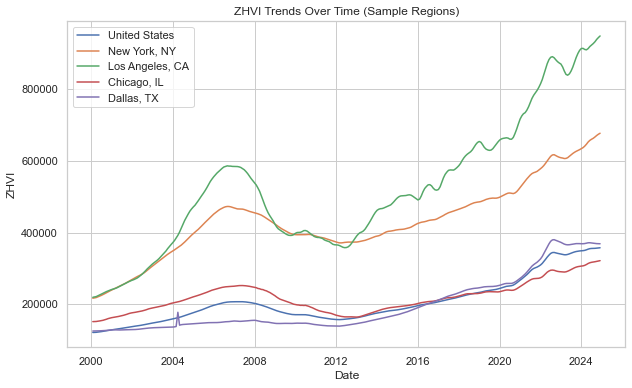

In [22]:
# Ensure the Date column is in datetime format
merged_data['Date'] = pd.to_datetime(merged_data['Date'], errors='coerce')

# Check for unique RegionName and filter properly
plt.figure(figsize=(10, 6))
for region in merged_data['RegionName'].dropna().unique()[:5]:  # Use the first 5 unique regions
    subset = merged_data[merged_data['RegionName'] == region]
    subset = subset.sort_values('Date')  # Ensure data is sorted by Date
    plt.plot(subset['Date'].values, subset['ZHVI'].values, label=region)

plt.title("ZHVI Trends Over Time (Sample Regions)")
plt.xlabel("Date")
plt.ylabel("ZHVI")
plt.legend(loc="upper left")
plt.show()


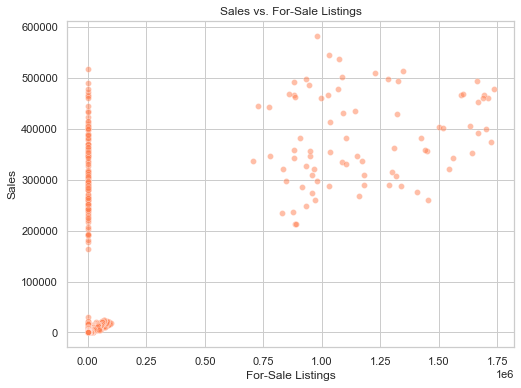

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=merged_data['ForSaleListings'].dropna().to_numpy(),
    y=merged_data['Sales'].dropna().to_numpy(),
    alpha=0.5,
    color="coral"
)
plt.title("Sales vs. For-Sale Listings")
plt.xlabel("For-Sale Listings")
plt.ylabel("Sales")
plt.show()


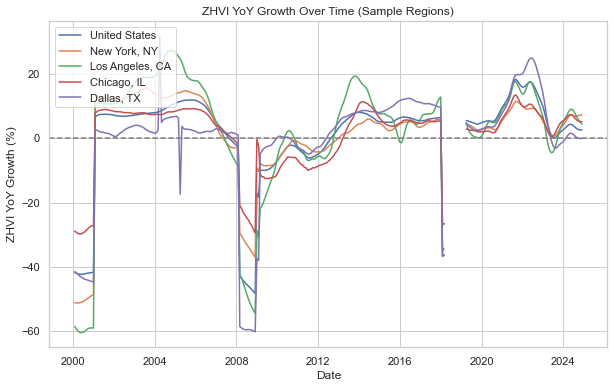

In [28]:
plt.figure(figsize=(10, 6))
for region in merged_data['RegionName'].dropna().unique()[:5]:  # Use the first 5 unique regions
    subset = merged_data[merged_data['RegionName'] == region].sort_values('Date')
    plt.plot(subset['Date'].to_numpy(), subset['ZHVI_YoY'].to_numpy(), label=region)

plt.title("ZHVI YoY Growth Over Time (Sample Regions)")
plt.xlabel("Date")
plt.ylabel("ZHVI YoY Growth (%)")
plt.axhline(0, color="gray", linestyle="--")  # Add a horizontal line at 0
plt.legend(loc="upper left")
plt.show()


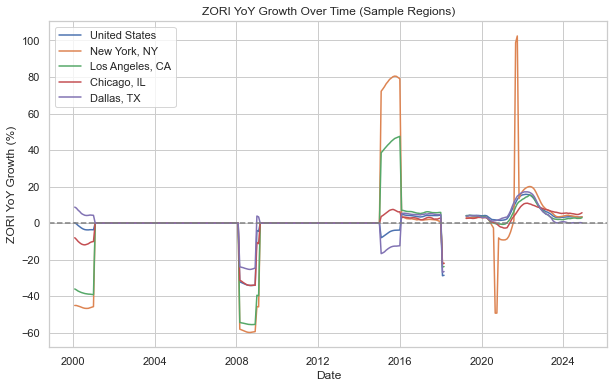

In [29]:
plt.figure(figsize=(10, 6))
for region in merged_data['RegionName'].dropna().unique()[:5]:  # Use the first 5 unique regions
    subset = merged_data[merged_data['RegionName'] == region].sort_values('Date')
    plt.plot(subset['Date'].to_numpy(), subset['ZORI_YoY'].to_numpy(), label=region)

plt.title("ZORI YoY Growth Over Time (Sample Regions)")
plt.xlabel("Date")
plt.ylabel("ZORI YoY Growth (%)")
plt.axhline(0, color="gray", linestyle="--")  # Add a horizontal line at 0
plt.legend(loc="upper left")
plt.show()


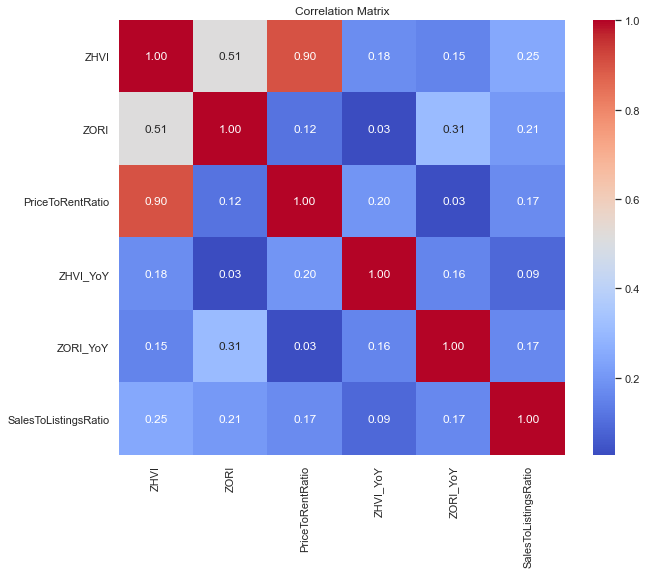

In [30]:
plt.figure(figsize=(10, 8))
correlation_matrix = merged_data[['ZHVI', 'ZORI', 'PriceToRentRatio', 'ZHVI_YoY', 'ZORI_YoY', 'SalesToListingsRatio']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


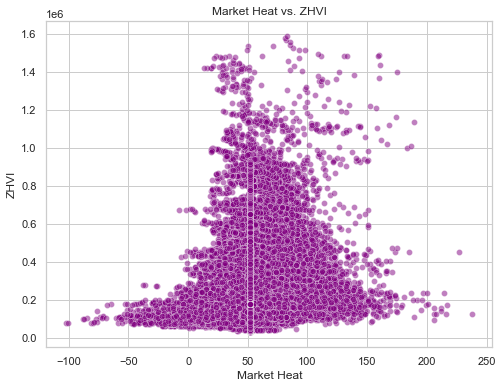

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=merged_data['MarketHeat'].dropna().to_numpy(),
    y=merged_data['ZHVI'].dropna().to_numpy(),
    alpha=0.5,
    color="purple"
)
plt.title("Market Heat vs. ZHVI")
plt.xlabel("Market Heat")
plt.ylabel("ZHVI")
plt.show()


In [41]:
# # Ensure the column contains only numeric values
# cleaned_price_to_rent = pd.to_numeric(merged_data['PriceToRentRatio'], errors='coerce').dropna()

# # Convert to a numpy array and flatten
# cleaned_price_to_rent = cleaned_price_to_rent.to_numpy()

# # Plot the histogram
# plt.figure(figsize=(8, 6))
# sns.histplot(x=cleaned_price_to_rent, kde=True, bins=30, color="skyblue")
# plt.title("Distribution of Price-to-Rent Ratio")
# plt.xlabel("Price-to-Rent Ratio")
# plt.ylabel("Frequency")
# plt.show()


In [40]:
# import numpy as np

# # Clean the Sales-to-Listings Ratio column
# cleaned_sales_to_listings = pd.to_numeric(merged_data['SalesToListingsRatio'], errors='coerce').dropna()

# # Remove invalid values: infinity, zero, or negative
# cleaned_sales_to_listings = cleaned_sales_to_listings[~np.isinf(cleaned_sales_to_listings)]
# cleaned_sales_to_listings = cleaned_sales_to_listings[cleaned_sales_to_listings > 0]

# # Convert to a numpy array and ensure it's one-dimensional
# cleaned_sales_to_listings = np.array(cleaned_sales_to_listings).flatten()

# # Debugging step: Ensure no multi-dimensional data
# print(f"Cleaned Data Shape: {cleaned_sales_to_listings.shape}")
# print(f"Sample Values: {cleaned_sales_to_listings[:10]}")

# # Plot the histogram
# plt.figure(figsize=(8, 6))
# sns.histplot(cleaned_sales_to_listings, kde=True, bins=30, color="green")  # Directly pass the clean 1D array
# plt.title("Distribution of Sales-to-Listings Ratio")
# plt.xlabel("Sales-to-Listings Ratio")
# plt.ylabel("Frequency")
# plt.show()


In [42]:
from sklearn.model_selection import train_test_split

# Select features and target
features = ['PriceToRentRatio', 'MarketHeat', 'SalesToListingsRatio', 'ZHVI_YoY', 'ZORI_YoY']
target = 'ZHVI'

# Ensure data contains no missing or infinite values
model_data = merged_data[features + [target]].replace([np.inf, -np.inf], np.nan).dropna()

# Split the data into features (X) and target (y)
X = model_data[features]
y = model_data[target]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (50544, 5)
X_test shape: (12636, 5)
y_train shape: (50544,)
y_test shape: (12636,)


In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance on Test Data:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Model Performance on Test Data:
Root Mean Squared Error (RMSE): 51191.711025607496
R² Score: 0.8858694345785164

Feature Importance:
                Feature  Importance
0      PriceToRentRatio    0.791153
4              ZORI_YoY    0.092264
3              ZHVI_YoY    0.047239
2  SalesToListingsRatio    0.036225
1            MarketHeat    0.033119


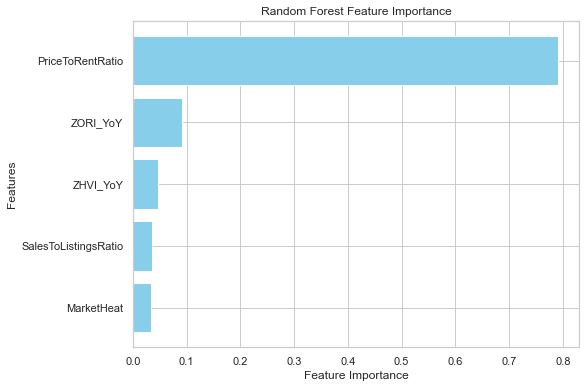

In [45]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


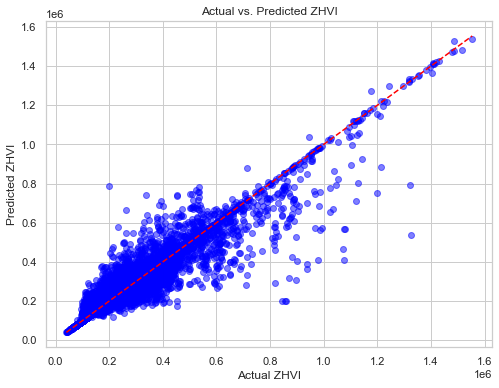

In [46]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Perfect prediction line
plt.xlabel("Actual ZHVI")
plt.ylabel("Predicted ZHVI")
plt.title("Actual vs. Predicted ZHVI")
plt.show()


In [47]:

from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean Cross-Validation R²: {cv_scores.mean()}")


Cross-Validation R² Scores: [0.72331463 0.80954319 0.76590635 0.74929236 0.87669362]
Mean Cross-Validation R²: 0.7849500304144319


# Train and Evaluate Gradient Boosting Regressor

In [49]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model on the training data
gb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting Model Performance on Test Data:")
print(f"Root Mean Squared Error (RMSE): {rmse_gb}")
print(f"R² Score: {r2_gb}")

# Feature Importance
feature_importance_gb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance_gb)


Gradient Boosting Model Performance on Test Data:
Root Mean Squared Error (RMSE): 61377.34267252119
R² Score: 0.8359339050976473

Feature Importance:
                Feature  Importance
0      PriceToRentRatio    0.896627
4              ZORI_YoY    0.060746
2  SalesToListingsRatio    0.035560
3              ZHVI_YoY    0.005706
1            MarketHeat    0.001361


# XG BOOST

In [50]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Model Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")
print(f"R² Score: {r2_xgb}")


XGBoost Model Performance:
Root Mean Squared Error (RMSE): 63721.233548845245
R² Score: 0.8231638599386796


In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Build the neural network
nn_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
nn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions on the test set
y_pred_nn = nn_model.predict(X_test).flatten()

# Evaluate the model
rmse_nn = mean_squared_error(y_test, y_pred_nn, squared=False)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network Model Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse_nn}")
print(f"R² Score: {r2_nn}")


Epoch 1/50
1264/1264 [==============================] - 3s 2ms/step - loss: 34964164608.0000 - val_loss: 7633708544.0000
Epoch 2/50
1264/1264 [==============================] - 2s 2ms/step - loss: 7240532992.0000 - val_loss: 6569248256.0000
Epoch 3/50
1264/1264 [==============================] - 2s 2ms/step - loss: 6518530560.0000 - val_loss: 6190642176.0000
Epoch 4/50
1264/1264 [==============================] - 2s 2ms/step - loss: 6300050432.0000 - val_loss: 6097477632.0000
Epoch 5/50
1264/1264 [==============================] - 2s 2ms/step - loss: 6231850496.0000 - val_loss: 6051499520.0000
Epoch 6/50
1264/1264 [==============================] - 2s 2ms/step - loss: 6197276160.0000 - val_loss: 6023657472.0000
Epoch 7/50
1264/1264 [==============================] - 2s 2ms/step - loss: 6175287808.0000 - val_loss: 6007084544.0000
Epoch 8/50
1264/1264 [==============================] - 2s 2ms/step - loss: 6166669824.0000 - val_loss: 5996588544.0000
Epoch 9/50
1264/1264 [=================

In [54]:
import pandas as pd

# Create a dictionary with model names and their metrics
model_performance = {
    "Model": ["Random Forest", "Gradient Boosting", "XGBoost", "Neural Network"],
    "RMSE": [51191.71, 61377.34, rmse_xgb, rmse_nn],
    "R²": [0.8859, 0.8359, r2_xgb, r2_nn]
}

# Convert the dictionary into a pandas DataFrame
performance_table = pd.DataFrame(model_performance)

# Display the table
print(performance_table)


               Model          RMSE        R²
0      Random Forest  51191.710000  0.885900
1  Gradient Boosting  61377.340000  0.835900
2            XGBoost  63721.233549  0.823164
3     Neural Network  75226.620996  0.753540


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter distribution
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=25,  # Number of random parameter combinations to test
    scoring='r2',
    cv=3,  # Reduced folds for faster processing
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters (Randomized Search):", random_search.best_params_)
print("Best Cross-Validation R² Score:", random_search.best_score_)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    scoring='r2', 
    cv=5, 
    verbose=2, 
    n_jobs=-1
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Display the best parameters and the corresponding R² score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation R² Score:", grid_search.best_score_)


In [56]:
# Reduced parameter grid
param_grid_reduced = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_reduced = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_reduced,
    scoring='r2',
    cv=3,  # Reduced folds for faster processing
    verbose=2,
    n_jobs=-1
)

grid_search_reduced.fit(X_train, y_train)

print("Best Parameters (Reduced Grid):", grid_search_reduced.best_params_)
print("Best Cross-Validation R² Score:", grid_search_reduced.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters (Reduced Grid): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation R² Score: 0.8682463338097035


In [57]:
# Train the final Random Forest model with the best parameters
final_rf_model = RandomForestRegressor(
    max_depth=None, 
    min_samples_leaf=1, 
    min_samples_split=2, 
    n_estimators=200, 
    random_state=42
)

final_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_final_rf = final_rf_model.predict(X_test)

# Evaluate the final model
rmse_final_rf = mean_squared_error(y_test, y_pred_final_rf, squared=False)
r2_final_rf = r2_score(y_test, y_pred_final_rf)

print(f"Final Random Forest Model Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse_final_rf}")
print(f"R² Score: {r2_final_rf}")


Final Random Forest Model Performance:
Root Mean Squared Error (RMSE): 51092.615173396654
R² Score: 0.8863108700654628


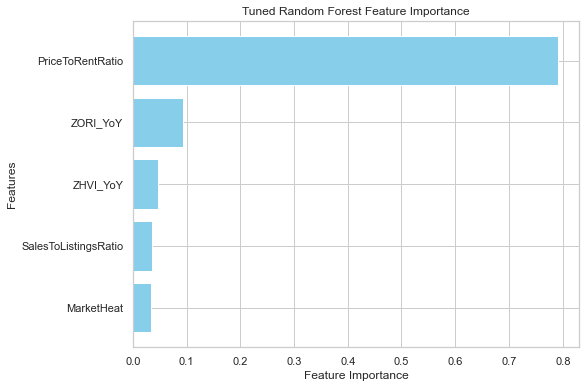

In [58]:
# Feature Importance
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Tuned Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()


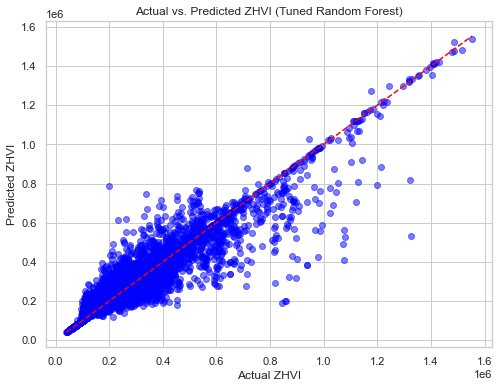

In [59]:
# Predicted vs. Actual Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_final_rf, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Perfect prediction line
plt.xlabel("Actual ZHVI")
plt.ylabel("Predicted ZHVI")
plt.title("Actual vs. Predicted ZHVI (Tuned Random Forest)")
plt.show()


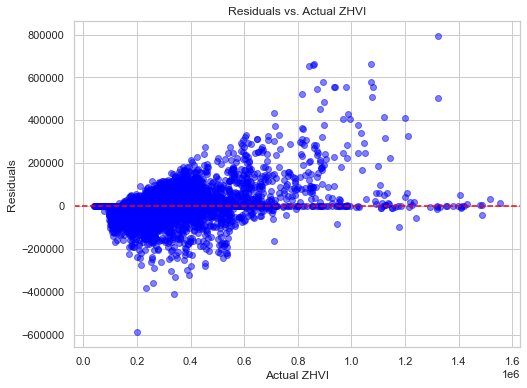

In [60]:
residuals = y_test - y_pred_final_rf

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.5, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual ZHVI")
plt.ylabel("Residuals")
plt.title("Residuals vs. Actual ZHVI")
plt.show()


In [62]:
merged_test = merged_data.loc[y_test.index]  # Match test data rows with original dataset
merged_test['Residuals'] = residuals

# Average residuals by state
state_residuals = merged_test.groupby('RegionName')['Residuals'].mean()
print(state_residuals.sort_values())


RegionName
Warrensburg, MO        -182006.281863
Idaho Falls, ID        -165146.463496
Grand Forks, ND        -148250.826196
Missoula, MT           -121038.120134
Oshkosh, WI            -116634.522580
                            ...      
Heber, UT               247230.054602
Key West, FL            259577.912527
Santa Cruz, CA          260111.934879
Santa Maria, CA         343835.495376
Glenwood Springs, CO    454344.223975
Name: Residuals, Length: 928, dtype: float64


In [64]:

import numpy as np

perturbed_data = X_test.copy()
perturbed_data['PriceToRentRatio'] = X_test['PriceToRentRatio'] * 1.1  # Increase by 10%

perturbed_predictions = final_rf_model.predict(perturbed_data)
impact = perturbed_predictions - y_pred_final_rf

print(f"Mean Prediction Change from PriceToRentRatio Perturbation: {np.mean(impact)}")


Mean Prediction Change from PriceToRentRatio Perturbation: 31628.75563532148


In [67]:
# Region-Level Actual vs. Predicted ZHVI
merged_test = merged_data.loc[y_test.index]  # Match test data rows with original dataset
merged_test['Predicted_ZHVI'] = y_pred_final_rf

# Aggregate by RegionName
region_predictions = merged_test.groupby('RegionName')[['ZHVI', 'Predicted_ZHVI']].mean()

# Calculate prediction error
region_predictions['Error'] = region_predictions['Predicted_ZHVI'] - region_predictions['ZHVI']

# Sort by Predicted ZHVI
region_comparison = region_predictions.sort_values(by='Predicted_ZHVI', ascending=False)
print(region_comparison.head(10))  # Display top 10 regions


                               ZHVI  Predicted_ZHVI         Error
RegionName                                                       
San Jose, CA           1.299430e+06    1.283095e+06 -16335.221401
Jackson, WY            1.158274e+06    1.158497e+06    223.217171
Vineyard Haven, MA     1.142946e+06    1.142066e+06   -879.364725
San Francisco, CA      1.069142e+06    1.030052e+06 -39089.731601
Edwards, CO            1.040254e+06    9.455350e+05 -94718.761997
Breckenridge, CO       8.504221e+05    8.432933e+05  -7128.821025
Hailey, ID             8.401895e+05    8.396564e+05   -533.161299
Steamboat Springs, CO  8.360327e+05    8.214146e+05 -14618.140383
Kapaa, HI              7.637204e+05    7.639364e+05    215.928084
Urban Honolulu, HI     7.769250e+05    7.546035e+05 -22321.510262


In [69]:
# Residual Analysis by RegionName
region_residuals = merged_test.groupby('RegionName')['Predicted_ZHVI'].mean() - merged_test.groupby('RegionName')['ZHVI'].mean()

# Display regions with the highest and lowest residuals
print("Regions with Highest Positive Residuals:")
print(region_residuals.nlargest(10))

print("\nRegions with Highest Negative Residuals:")
print(region_residuals.nsmallest(10))


Regions with Highest Positive Residuals:
RegionName
Warrensburg, MO       182006.281863
Idaho Falls, ID       165146.463496
Grand Forks, ND       148250.826196
Missoula, MT          121038.120134
Oshkosh, WI           116634.522580
Logan, UT             109998.232325
Frankfort, KY         107857.392562
Portland, OR          103377.378184
Salt Lake City, UT    101715.684927
Laramie, WY           100654.423757
dtype: float64

Regions with Highest Negative Residuals:
RegionName
Glenwood Springs, CO   -454344.223975
Santa Maria, CA        -343835.495376
Santa Cruz, CA         -260111.934879
Key West, FL           -259577.912527
Heber, UT              -247230.054602
Naples, FL             -234721.177429
Kahului, HI            -199053.175786
Napa, CA               -198943.729831
Barnstable Town, MA    -155386.685505
Oxnard, CA             -144446.171353
dtype: float64


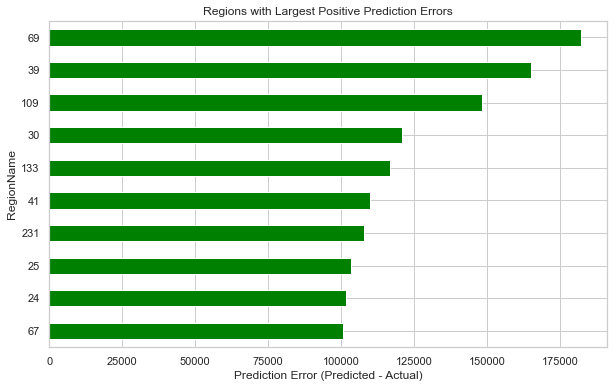

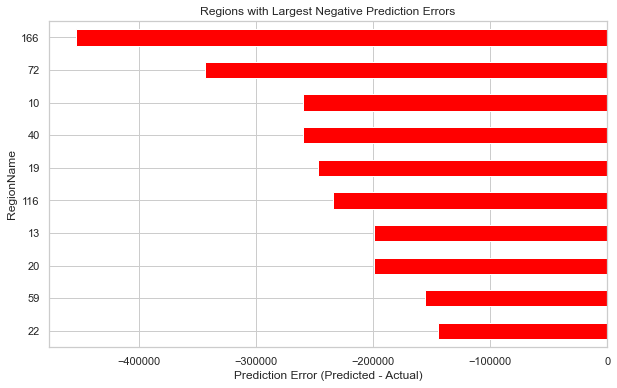

In [70]:
# Bar plot for regions with the largest prediction errors
top_regions = region_comparison.nlargest(10, 'Error')
bottom_regions = region_comparison.nsmallest(10, 'Error')

# Plot largest positive errors
top_regions['Error'].plot(kind='barh', figsize=(10, 6), title="Regions with Largest Positive Prediction Errors", color='green')
plt.xlabel("Prediction Error (Predicted - Actual)")
plt.ylabel("RegionName")
plt.gca().invert_yaxis()
plt.show()

# Plot largest negative errors
bottom_regions['Error'].plot(kind='barh', figsize=(10, 6), title="Regions with Largest Negative Prediction Errors", color='red')
plt.xlabel("Prediction Error (Predicted - Actual)")
plt.ylabel("RegionName")
plt.gca().invert_yaxis()
plt.show()


In [71]:
import plotly.express as px

# Example data preparation for a map visualization
region_comparison.reset_index(inplace=True)

# Add dummy RegionID or geographical keys (adjust based on your dataset)
region_comparison['RegionID'] = merged_test.groupby('RegionName')['RegionID'].first().values  

# Generate a choropleth map
fig = px.choropleth(
    region_comparison,
    locations='RegionID',  # Replace with actual geographic identifiers
    locationmode='USA-states',  # Adjust based on your dataset
    color='Error',
    hover_name='RegionName',
    color_continuous_scale='Viridis',
    title='Prediction Errors by Region'
)
fig.show()


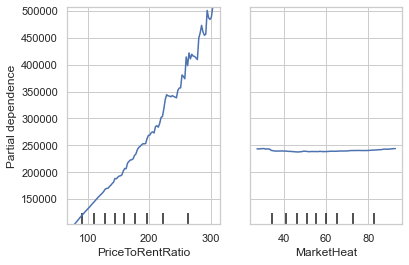

In [73]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(final_rf_model, X_train, features=['PriceToRentRatio', 'MarketHeat'])
plt.show()


In [ ]:
import shap

explainer = shap.TreeExplainer(final_rf_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


In [ ]:
from scipy.stats import ttest_rel

# Predictions from Random Forest and Gradient Boosting
y_pred_gbm = gb_model.predict(X_test)

# Paired t-test
t_stat, p_value = ttest_rel(y_pred_final_rf, y_pred_gbm)
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")
